# G@C participation demographics (age) found from survey

Model Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8605      0.230     -3.742      0.000      -1.311      -0.410
Age_code       0.4141      0.126      3.286      0.001       0.167       0.661

McFadden pseudo R-squared: 0.0733


/Users/a1234/.pyenv/versions/3.13.1/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


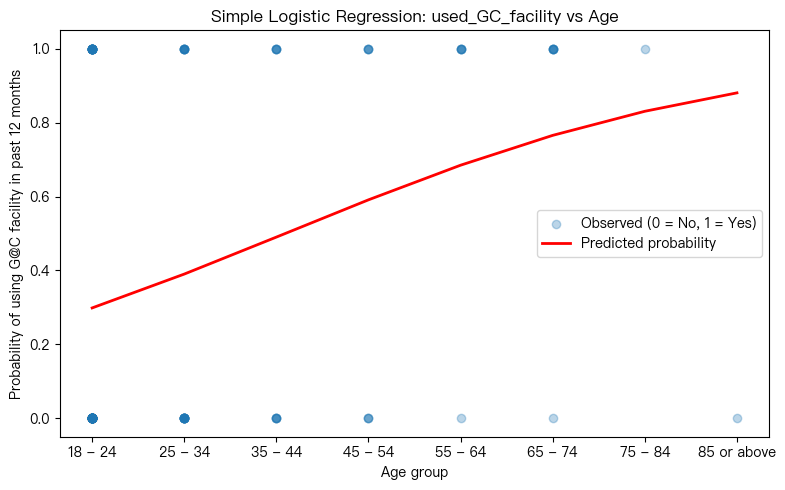

In [6]:
# !pip install pandas numpy matplotlib scikit-learn statsmodels openpyxl
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix

from statsmodels.miscmodels.ordinal_model import OrderedModel
import statsmodels.api as sm

import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")

# -------------------------------------------------
# Identify the relevant columns by (partial) name
use_col = [c for c in df.columns if "In the past 12 months" in str(c)][0]
age_col = [c for c in df.columns if "Age" in str(c)][0]

# Keep only rows with valid Yes/No answers and age groups
df_use = df[[use_col, age_col]].copy()

# Binary outcome: 1 = Yes, 0 = No
df_use["used_gc"] = df_use[use_col].map({"Yes": 1, "No": 0})

# Ordered age groups
age_order = [
    "18 - 24",
    "25 - 34",
    "35 - 44",
    "45 - 54",
    "55 - 64",
    "65 - 74",
    "75 - 84",
    "85 or above",
]

age_cat = pd.Categorical(df_use[age_col], categories=age_order, ordered=True)
df_use["Age_code"] = age_cat.codes  # 0 for 18–24, 1 for 25–34, ..., 7 for 85+

# Drop rows with missing / undefined age or use status
mask = df_use["used_gc"].notna() & (df_use["Age_code"] >= 0)
X_age = df_use.loc[mask, ["Age_code"]]
y_use = df_use.loc[mask, "used_gc"]

# Fit model using sklearn for predictions
lin_reg_age = LogisticRegression()
lin_reg_age.fit(X_age, y_use)

# Fit model using statsmodels for statistical tests
X_age_sm = sm.add_constant(X_age)  # Add constant term for intercept
model_age = sm.Logit(y_use, X_age_sm)
results_age = model_age.fit(disp=False)

# Predictions for plotting (probability of "Yes")
y_pred_prob = lin_reg_age.predict_proba(X_age)[:, 1]

print("Model Summary:")
print(results_age.summary().tables[1])  # Print coefficient statistics

# McFadden pseudo R-squared
pseudo_r2 = 1 - results_age.llf / results_age.llnull
print(f"\nMcFadden pseudo R-squared: {pseudo_r2:.4f}")

# Plot
plt.figure(figsize=(8, 5))

# Scatter actual data (Age_code vs used_gc)
plt.scatter(
    X_age["Age_code"],
    y_use,
    alpha=0.3,
    label="Observed (0 = No, 1 = Yes)",
)

# Smooth predicted curve over the age codes
age_grid = np.arange(X_age["Age_code"].min(), X_age["Age_code"].max() + 1).reshape(-1, 1)
prob_grid = lin_reg_age.predict_proba(age_grid)[:, 1]
plt.plot(age_grid, prob_grid, color="red", linewidth=2, label="Predicted probability")

# Nice age labels on the x-axis
plt.xticks(ticks=np.arange(len(age_order)), labels=age_order, rotation=0)
plt.ylim(-0.05, 1.05)

plt.xlabel("Age group")
plt.ylabel("Probability of using G@C facility in past 12 months")
plt.title("Simple Logistic Regression: used_GC_facility vs Age")
plt.legend()
plt.tight_layout()
plt.show()


**Age coefficient ($\hat \beta_1$) = 0.41 (p = 0.001 < 0.05)**  

- There is a **statistically significant positive association** between age and the likelihood of having used a Green@Community recycling facility in the past 12 months. Older age groups are more likely to have used the facilities than younger age groups.  

- The corresponding odds ratio is about **1.51**, meaning that **for each step up in age group, the odds of having used a G@C facility increase by roughly 51%**.  

- The McFadden pseudo-R-squared is about **0.07**, so while age is a significant predictor, **age alone explains only a modest proportion of the variation** in whether people used the facilities; other factors (e.g. awareness, distance, attitudes) likely also play important roles.
